In [2]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [3]:
#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [4]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [7]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('./Dataset/train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( './Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [8]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

In [9]:
# Freezing Layers
for layer in base_model.layers[:fre]:
    layer.trainable=False

In [10]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         589952    
                                                      

In [11]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [13]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

Wall time: 0 ns


C:\Users\HP\AppData\Local\Temp\ipykernel_9188\1157127437.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


Epoch 1/8
256/256 [==============================] - 2355s 9s/step - loss: 0.6402 - accuracy: 0.6772 - val_loss: 0.5376 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 2/8
256/256 [==============================] - 3323s 13s/step - loss: 0.3838 - accuracy: 0.8310 - val_loss: 0.2987 - val_accuracy: 0.9102 - lr: 0.0010
Epoch 3/8
256/256 [==============================] - 2267s 9s/step - loss: 0.2698 - accuracy: 0.8936 - val_loss: 0.9298 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 4/8
256/256 [==============================] - 2163s 8s/step - loss: 0.2269 - accuracy: 0.9080 - val_loss: 0.3252 - val_accuracy: 0.9105 - lr: 0.0010
Epoch 5/8
256/256 [==============================] - 2921s 11s/step - loss: 0.1971 - accuracy: 0.9239 - val_loss: 0.1699 - val_accuracy: 0.9417 - lr: 0.0010
Epoch 6/8
256/256 [==============================] - 2418s 9s/step - loss: 0.1858 - accuracy: 0.9246 - val_loss: 0.1548 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 7/8
256/256 [==============================] - 2254s 9s/

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 64ms/step
[0.54685974]
This  is a female


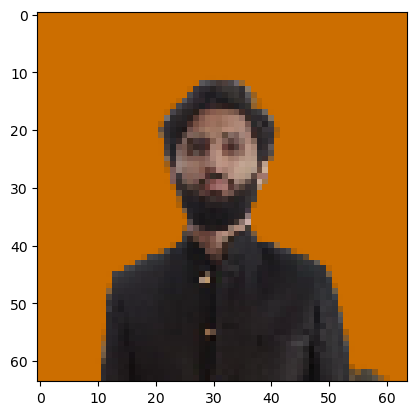

In [34]:
import numpy as np

from tensorflow.keras.preprocessing import image
#  images test 1
img = './image/ahmad.png'
path_testmodel = "./Dataset/Test/Female/179661.jpg"
imge = image.load_img(img, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

1/1 [==============================] - 0s 133ms/step
[0.54685974]
This is a male


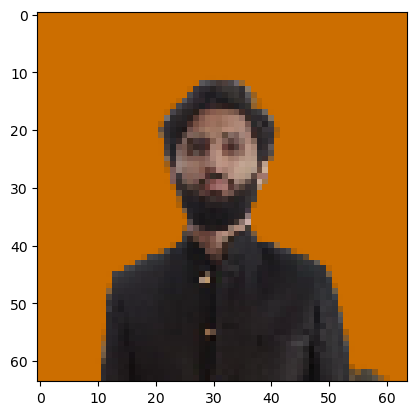

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
#  images test 2
img = './image/ahmad.png'
path_testmodel = "./Dataset/Test/Male/160002.jpg"
imge = image.load_img(img, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
plt.imshow(imge)